# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [36]:
print("start...")
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
print("end...")

start...
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
end...


In [37]:
print("start...")
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # 1.Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # 2.subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # 3.Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1)) #equals to np.reshap(X_train,(shape0,shape1*shape2*shape3))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # 4.Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0) #sum for each column(each column as feature)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # 5.add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape
print("end...")

start...
Train data shape:  (49000L, 3073L)
Train labels shape:  (49000L,)
Validation data shape:  (1000L, 3073L)
Validation labels shape:  (1000L,)
Test data shape:  (1000L, 3073L)
Test labels shape:  (1000L,)
dev data shape:  (500L, 3073L)
dev labels shape:  (500L,)
end...


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [38]:
# First implement the naive softmax loss function with nested loops.(loop with loop---->two loops)
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.
print("start...")
from cs231n.classifiers.softmax import softmax_loss_naive
from cs231n.classifiers.softmax import softmax_loss_vectorized
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)
print("loss:",loss)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))
print("end...")

start...
('loss:', 2.3216499042553709)
loss: 2.321650
sanity check: 2.302585
end...


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*
1.for any ith row,softmax function is: np.exp(score[y[i])/np.sum(np.exp(scores[i])). when we initize the weight, it is very small,<br/> and close to zero. so score,that is W multipy X, is close to zero; as a result,numerator is 1, and denominator is number of classes,<br/> in our case, it is 10.<br/>
so 1/10 is equal to 0.1(as softmax_result).<br/>
for the loss function, it is -np.log(softmax_result), so it is -np.log(0.1)

In [43]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
print("start...")
loss, grad =softmax_loss_naive(W, X_dev, y_dev, 0.0) #softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]#softmax_loss_naive
grad_numerical = grad_check_sparse(f, W, grad, 10)
print("....")
# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2) #softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0] #softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)
print("end...")

start...
numerical: 2.631416 analytic: 2.631416, relative error: 9.838629e-09
numerical: 0.530180 analytic: 0.530180, relative error: 1.920618e-08
numerical: 0.076038 analytic: 0.076038, relative error: 9.452257e-08
numerical: 0.833199 analytic: 0.833199, relative error: 6.124216e-09
numerical: 0.067454 analytic: 0.067454, relative error: 3.978997e-07
numerical: -0.712539 analytic: -0.712539, relative error: 3.000484e-08
numerical: 2.203213 analytic: 2.203213, relative error: 4.651518e-08
numerical: -0.414549 analytic: -0.414549, relative error: 4.316684e-08
numerical: 2.724464 analytic: 2.724464, relative error: 1.442143e-08
numerical: 0.764052 analytic: 0.764051, relative error: 9.819666e-08
....
numerical: 0.519569 analytic: 0.519569, relative error: 4.270785e-08
numerical: 0.628154 analytic: 0.628154, relative error: 4.701936e-08
numerical: -0.213334 analytic: -0.213334, relative error: 8.001682e-08
numerical: 1.904638 analytic: 1.904638, relative error: 1.414706e-08
numerical: -1.

In [11]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
print("start...")
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference
print("end...")

start...
naive loss: 2.346697e+00 computed in 0.062000s
('dW.shape:', (3073L, 10L))
vectorized loss: 2.346697e+00 computed in 0.005000s
Loss difference: 0.000000
Gradient difference: 317.727855
end...


In [14]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set. --->lr lr 1.000000e-06 reg 1.000000e+04 train accuracy: 0.358857 val accuracy: 0.355000
#lr 1.000000e-06 reg 1.000000e+04 train accuracy: 0.364449 val accuracy: 0.352000                                                                        
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates =[1e-5,1e-6,5e-6,1e-7,2.5e-7, 5e-7] #[1e-7, 5e-7]--->[1e-4,1e-5,1e-6,5e-6,1e-7,2.5e-7, 5e-7,1e-8]
regularization_strengths =[1e3,1e4,1e5,5e5,1e6] #[5e4, 1e8]-->[1e3,1e4,5e4,5e5,1e6,5e6,1e7,1e8,1e9]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
#pass
softmax = Softmax()
for lr in learning_rates:
    for r in regularization_strengths:
        #1.train
        softmax.train(X_train, y_train, learning_rate=lr, reg=r, 
                      num_iters=300, verbose=True) #1500
        #2.predict,and calculate accuracy
        y_train_pred=softmax.predict(X_train)
        y_val_pred=softmax.predict(X_val)
        accuracy_train=np.mean(y_train_pred==y_train)
        accuracy_val=np.mean(y_val_pred==y_val)
        #3.save result
        results[(lr,r)]=(accuracy_train,accuracy_val)
        #4.if better, save as best_val,best_softmax
        if accuracy_val>best_val:
            best_val=accuracy_val
            best_softmax=softmax
            y_test_pred=softmax.predict(X_test)
            accuracy_test=np.mean(y_test_pred==y_test)
            print("learning rate:",lr,"regular_strengths:",r,"accuracy_test:",accuracy_test)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 300: loss 21.566723
iteration 100 / 300: loss 5.570434
iteration 200 / 300: loss 3.344036
('learning rate:', 1e-05, 'regular_strengths:', 1000.0, 'accuracy_test:', 0.29199999999999998)
iteration 0 / 300: loss 157.652050
iteration 100 / 300: loss 4.589216
iteration 200 / 300: loss 4.345975
iteration 0 / 300: loss 1551.423755
iteration 100 / 300: loss 19.719570
iteration 200 / 300: loss 16.984240
iteration 0 / 300: loss 7689.858386
iteration 100 / 300: loss inf
iteration 200 / 300: loss inf
iteration 0 / 300: loss 15423.912099
iteration 100 / 300: loss inf
iteration 200 / 300: loss inf
iteration 0 / 300: loss 20.666448
iteration 100 / 300: loss 15.222456
iteration 200 / 300: loss 12.680169
iteration 0 / 300: loss 161.546151
iteration 100 / 300: loss 22.541995
iteration 200 / 300: loss 4.684633
('learning rate:', 1e-06, 'regular_strengths:', 10000.0, 'accuracy_test:', 0.35499999999999998)
iteration 0 / 300: loss 1535.325406
iteration 100 / 300: loss 2.125825
iteration 200 / 

In [15]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.278000


In [21]:
#evaluate on test set using best trained model
softmax=Softmax()
lr=6e-7#1e-6
r=1e4
softmax.train(X_train, y_train, learning_rate=lr, reg=r, 
                      num_iters=1500, verbose=True)
best_softmax=softmax
y_test_pred=softmax.predict(X_test)
accuracy_test=np.mean(y_test_pred==y_test)
print("accuracy_test:",accuracy_test)

iteration 0 / 1500: loss 159.923103
iteration 100 / 1500: loss 48.127845
iteration 200 / 1500: loss 15.642872
iteration 300 / 1500: loss 6.037742
iteration 400 / 1500: loss 3.250453
iteration 500 / 1500: loss 2.375949
iteration 600 / 1500: loss 2.024426
iteration 700 / 1500: loss 1.878015
iteration 800 / 1500: loss 1.925388
iteration 900 / 1500: loss 1.924377
iteration 1000 / 1500: loss 1.890963
iteration 1100 / 1500: loss 1.861754
iteration 1200 / 1500: loss 1.955411
iteration 1300 / 1500: loss 1.976125
iteration 1400 / 1500: loss 2.033321
('accuracy_test:', 0.372)


start...
end...


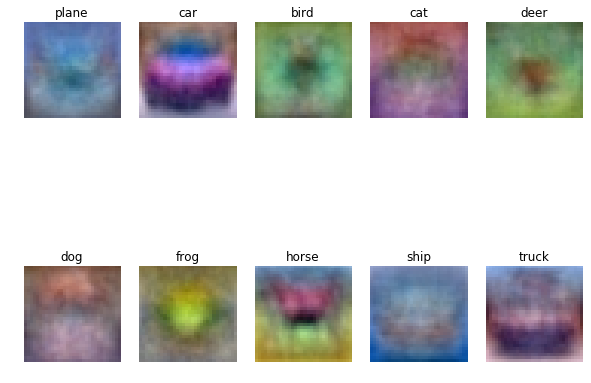

In [22]:
# Visualize the learned weights for each class
print("start...")
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])
print("end...")

Comments: as i can see from above 'weight' images, some visualized version of weight can be easily related to their real categories.<br/>
for example, for picture with lable 'horse', it is easy to recognize it is a horse. it also true for 'car'.<br/>
and although it is not so easy to see the shape of 'ship' for label picture,but in the above pictue there is lots of blue colors, which is simliar with real ship image(ship usually on the sea, and sea's color is blue)